In [1]:
!pip uninstall openpyxl -y
!pip install openpyxl

Found existing installation: openpyxl 3.0.3
Uninstalling openpyxl-3.0.3:
  Successfully uninstalled openpyxl-3.0.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 18.8 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import openpyxl
import numpy as np
import pandas as pd
import math
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from statistics import mean
from sklearn.model_selection import cross_validate, KFold, GridSearchCV

In [3]:
print(openpyxl.__version__)

3.1.2


0
1
2
3
4
5
6
7
8
9
{'C': [1], 'gamma': [0.0001]}
{'C': 1, 'gamma': 0.0001}
train: 1.0
5%: 0.9854887790034235
13%: 1.0
29%: 1.0
43%: 1.0
{'C': 1, 'gamma': 0.0001}
train: 1.0
5%: 0.9870981226723416
13%: 1.0
29%: 1.0
43%: 1.0
{'C': 1, 'gamma': 0.0001}
train: 1.0
5%: 0.974156919337688
13%: 1.0
29%: 1.0
43%: 1.0
{'C': 1, 'gamma': 0.0001}
train: 1.0
5%: 0.9729159539286121
13%: 1.0
29%: 1.0
43%: 1.0
{'C': 1, 'gamma': 0.0001}
train: 1.0
5%: 0.979475982532751
13%: 1.0
29%: 1.0
43%: 1.0
{'C': 1, 'gamma': 0.0001}
train: 1.0
5%: 0.9811804474153974
13%: 1.0
29%: 1.0
43%: 1.0
{'C': 1, 'gamma': 0.0001}
train: 1.0
5%: 0.9896003650328911
13%: 1.0
29%: 1.0
43%: 1.0
{'C': 1, 'gamma': 0.0001}
train: 1.0
5%: 0.9779003423354887
13%: 1.0
29%: 1.0
43%: 1.0
{'C': 1, 'gamma': 0.0001}
train: 1.0
5%: 0.9757400999615533
13%: 1.0
29%: 1.0
43%: 1.0
{'C': 1, 'gamma': 0.0001}
train: 1.0
5%: 0.9836149610784128
13%: 1.0
29%: 1.0
43%: 1.0
Average performance:
5%: 0.9807171973298561
13%: 1.0
29%: 1.0
43%: 1.0
Average: 0.

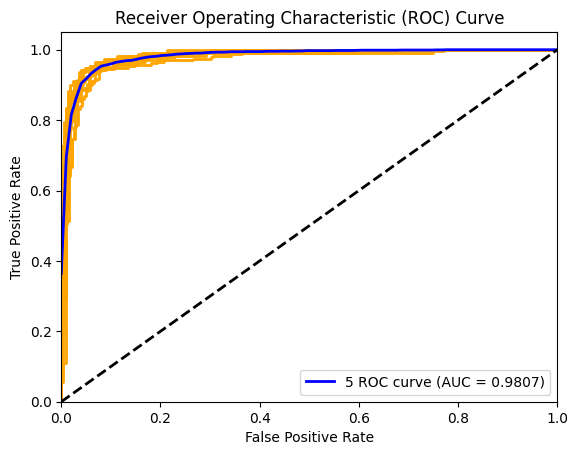

In [38]:
#Specify datasets
df = pd.read_excel(
    io='Dataset.xlsx',
    usecols="B:K"
)

#run settings
training_cont = 29
raw_cols = [3,4,5,6,7,8,9,10]
LDH_cols = [3,4,11,15]
Pot_cols = [5,6,12,16]
Cal_cols = [7,8,9,10,13,14,17,18]
feature_cols = Cal_cols
no_folds = 10 #number of external folds
no_folds_inner = 5 #number of internal folds

fold_size = len(df) // no_folds #number of records in each fold

#create data structures to store results
scores = [[] for _ in range(4)]  # Create a list of 4 empty lists
parameters = []
coefficient_sum = np.zeros((1, len(feature_cols)))
tpr_values_5 = []
tpr_values_13 = []
tpr_values_29 = []
tpr_values_43 = []
mean_fpr = np.linspace(0, 1, 100)

#Select half of all sample pairs to modify
num_cells_to_modify = int(len(df)/4)
df_to_modify = df.drop(0) #make it such that cells_to_modify and cells_to_modify_2 do not contain 0
cells_to_modify = df_to_modify.sample(n=num_cells_to_modify, random_state=1).index #select quarter of sample pairs for contamination of first record
df_remainder = df_to_modify.drop(cells_to_modify)
cells_to_modify_2 = df_remainder.sample(n=num_cells_to_modify, random_state=1).index #select quarter of sample pairs for contamination  of second record

#add labelling column for cells_to_modify
cells_to_modify_combined = cells_to_modify.append(cells_to_modify_2)
cells_to_modify_df = cells_to_modify_combined.to_frame()
cells_to_modify_df = cells_to_modify_df.rename(columns={0: 'Contaminated'})
new_index = range(len(df))
cells_to_modify_df = cells_to_modify_df.reindex(new_index)
cells_to_modify_df.fillna(value=0, inplace=True)
cells_to_modify_df.loc[(cells_to_modify_df['Contaminated']!=False),'Contaminated'] = 1
#merge 'Contaminated' dataframe with 'df' dataframe
df = cells_to_modify_df.merge(df, left_index=True, right_index=True, how='left')

# print(df.iloc[:,1:10].head(15))
# df.to_excel('Reformatted/df.xlsx')

#find out appropeiate dp to round to
original_decimals_pot = df['Potassium 2'].apply(lambda x: len(str(x).split('.')[1]))[0]
original_decimals_phos = df['Phosphate 2'].apply(lambda x: len(str(x).split('.')[1]))[0]
original_decimals_cal = df['Calcium 2'].apply(lambda x: len(str(x).split('.')[1]))[0]

#create plot for overfitting checker
plt.figure()

#plot hyperplane
# def plot_decision_boundary(clf, X, y):
#     # Get the min and max values of the features
#     x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#     y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

#     # Create a meshgrid for the feature space
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

#     # Compute the model predictions for each point in the meshgrid
#     Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)

#     # Plot the decision boundary
#     plt.contourf(xx, yy, Z, alpha=0.8)
#     plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=80)
#     plt.xlabel('Feature 1')
#     plt.ylabel('Feature 2')
#     plt.title('Logistic Regression Decision Boundary')
#     plt.show()

#outer loop of nested cross validation
for i in range(no_folds):
# for i in range(1):
    # Calculate indices for the current fold
    test_indices = list(range(i * fold_size, (i + 1) * fold_size))
    train_indices = list(set(range(len(df))) - set(test_indices))

    print(i)
    # print(min(train_indices))
    # print(max(train_indices))

    # Split the data into training and test sets
    df_train, df_test = df.iloc[train_indices].copy(), df.iloc[test_indices].copy()

    df_test_13 = df_test.copy()
    df_test_29 = df_test.copy()
    df_test_43 = df_test.copy()

    # Remove test_indices from cells_to_modify and cells_to_modify_2
    cells_to_modify_train = cells_to_modify.difference(test_indices)
    cells_to_modify_2_train = cells_to_modify_2.difference(test_indices)

    # Remove train_indices from cells_to_modify and cells_to_modify_2
    cells_to_modify_test = cells_to_modify.difference(train_indices)
    cells_to_modify_2_test = cells_to_modify_2.difference(train_indices)

    if training_cont == 5:
    #modify training set by 5%
        df_train.loc[cells_to_modify_train, 'LDH 1'] = (df_train.loc[cells_to_modify_train, 'LDH 1'] * 0.86).round(0)
        df_train.loc[cells_to_modify_train, 'Potassium 1'] = (df_train.loc[cells_to_modify_train, 'Potassium 1'] * 1.15).round(original_decimals_pot)
        df_train.loc[cells_to_modify_train, 'Phosphate 1'] = (df_train.loc[cells_to_modify_train, 'Phosphate 1'] * 1.01)
        df_train.loc[cells_to_modify_train, 'Calcium 1'] = (df_train.loc[cells_to_modify_train, 'Calcium 1'] * 0.88).round(original_decimals_cal)
        df_train.loc[cells_to_modify_2_train, 'LDH 2'] = (df_train.loc[cells_to_modify_2_train, 'LDH 2'] * 0.86).round(0)
        df_train.loc[cells_to_modify_2_train, 'Potassium 2'] = (df_train.loc[cells_to_modify_2_train, 'Potassium 2'] * 1.15).round(original_decimals_pot)
        df_train.loc[cells_to_modify_2_train, 'Phosphate 2'] = (df_train.loc[cells_to_modify_2_train, 'Phosphate 2'] * 1.01)
        df_train.loc[cells_to_modify_2_train, 'Calcium 2'] = (df_train.loc[cells_to_modify_2_train, 'Calcium 2'] * 0.88).round(original_decimals_cal)
    elif training_cont == 13:
        df_train.loc[cells_to_modify_train, 'LDH 1'] = (df_train.loc[cells_to_modify_train, 'LDH 1'] * 0.8).round(0)
        df_train.loc[cells_to_modify_train, 'Potassium 1'] = (df_train.loc[cells_to_modify_train, 'Potassium 1'] * 1.47).round(original_decimals_pot)
        df_train.loc[cells_to_modify_train, 'Phosphate 1'] = (df_train.loc[cells_to_modify_train, 'Phosphate 1'] * 1.03)
        df_train.loc[cells_to_modify_train, 'Calcium 1'] = (df_train.loc[cells_to_modify_train, 'Calcium 1'] * 0.67).round(original_decimals_cal)
        df_train.loc[cells_to_modify_2_train, 'LDH 2'] = (df_train.loc[cells_to_modify_2_train, 'LDH 2'] * 0.8).round(0)
        df_train.loc[cells_to_modify_2_train, 'Potassium 2'] = (df_train.loc[cells_to_modify_2_train, 'Potassium 2'] * 1.47).round(original_decimals_pot)
        df_train.loc[cells_to_modify_2_train, 'Phosphate 2'] = (df_train.loc[cells_to_modify_2_train, 'Phosphate 2'] * 1.03)
        df_train.loc[cells_to_modify_2_train, 'Calcium 2'] = (df_train.loc[cells_to_modify_2_train, 'Calcium 2'] * 0.67).round(original_decimals_cal)
    elif training_cont == 29:
        df_train.loc[cells_to_modify_train, 'LDH 1'] = (df_train.loc[cells_to_modify_train, 'LDH 1'] * 0.76).round(0)
        df_train.loc[cells_to_modify_train, 'Potassium 1'] = (df_train.loc[cells_to_modify_train, 'Potassium 1'] * 2.14).round(original_decimals_pot)
        df_train.loc[cells_to_modify_train, 'Phosphate 1'] = (df_train.loc[cells_to_modify_train, 'Phosphate 1'] * 1.07)
        df_train.loc[cells_to_modify_train, 'Calcium 1'] = (df_train.loc[cells_to_modify_train, 'Calcium 1'] * 0.25).round(original_decimals_cal)
        df_train.loc[cells_to_modify_2_train, 'LDH 2'] = (df_train.loc[cells_to_modify_2_train, 'LDH 2'] * 0.76).round(0)
        df_train.loc[cells_to_modify_2_train, 'Potassium 2'] = (df_train.loc[cells_to_modify_2_train, 'Potassium 2'] * 2.14).round(original_decimals_pot)
        df_train.loc[cells_to_modify_2_train, 'Phosphate 2'] = (df_train.loc[cells_to_modify_2_train, 'Phosphate 2'] * 1.07)
        df_train.loc[cells_to_modify_2_train, 'Calcium 2'] = (df_train.loc[cells_to_modify_2_train, 'Calcium 2'] * 0.25).round(original_decimals_cal)
    elif training_cont == 43:
        df_train.loc[cells_to_modify_train, 'LDH 1'] = (df_train.loc[cells_to_modify_train, 'LDH 1'] * 0.69).round(0)
        df_train.loc[cells_to_modify_train, 'Potassium 1'] = (df_train.loc[cells_to_modify_train, 'Potassium 1'] * 2.75).round(original_decimals_pot)
        df_train.loc[cells_to_modify_train, 'Phosphate 1'] = (df_train.loc[cells_to_modify_train, 'Phosphate 1'] * 1.09)
        df_train.loc[cells_to_modify_train, 'Calcium 1'] = (df_train.loc[cells_to_modify_train, 'Calcium 1'] * 0).round(original_decimals_cal)
        df_train.loc[cells_to_modify_2_train, 'LDH 2'] = (df_train.loc[cells_to_modify_2_train, 'LDH 2'] * 0.69).round(0)
        df_train.loc[cells_to_modify_2_train, 'Potassium 2'] = (df_train.loc[cells_to_modify_2_train, 'Potassium 2'] * 2.75).round(original_decimals_pot)
        df_train.loc[cells_to_modify_2_train, 'Phosphate 2'] = (df_train.loc[cells_to_modify_2_train, 'Phosphate 2'] * 1.09)
        df_train.loc[cells_to_modify_2_train, 'Calcium 2'] = (df_train.loc[cells_to_modify_2_train, 'Calcium 2'] * 0).round(original_decimals_cal)

    #modify df_test set by 5%
    df_test.loc[cells_to_modify_test, 'LDH 1'] = (df_test.loc[cells_to_modify_test, 'LDH 1'] * 0.86).round(0)
    df_test.loc[cells_to_modify_test, 'Potassium 1'] = (df_test.loc[cells_to_modify_test, 'Potassium 1'] * 1.15).round(original_decimals_pot)
    df_test.loc[cells_to_modify_test, 'Phosphate 1'] = (df_test.loc[cells_to_modify_test, 'Phosphate 1'] * 1.01)
    df_test.loc[cells_to_modify_test, 'Calcium 1'] = (df_test.loc[cells_to_modify_test, 'Calcium 1'] * 0.88).round(original_decimals_cal)
    df_test.loc[cells_to_modify_2_test, 'LDH 2'] = (df_test.loc[cells_to_modify_2_test, 'LDH 2'] * 0.86).round(0)
    df_test.loc[cells_to_modify_2_test, 'Potassium 2'] = (df_test.loc[cells_to_modify_2_test, 'Potassium 2'] * 1.15).round(original_decimals_pot)
    df_test.loc[cells_to_modify_2_test, 'Phosphate 2'] = (df_test.loc[cells_to_modify_2_test, 'Phosphate 2'] * 1.01)
    df_test.loc[cells_to_modify_2_test, 'Calcium 2'] = (df_test.loc[cells_to_modify_2_test, 'Calcium 2'] * 0.88).round(original_decimals_cal)

    #modify test set by 13%
    df_test_13.loc[cells_to_modify_test, 'LDH 1'] = (df_test_13.loc[cells_to_modify_test, 'LDH 1'] * 0.8).round(0)
    df_test_13.loc[cells_to_modify_test, 'Potassium 1'] = (df_test_13.loc[cells_to_modify_test, 'Potassium 1'] * 1.47).round(original_decimals_pot)
    df_test_13.loc[cells_to_modify_test, 'Phosphate 1'] = (df_test_13.loc[cells_to_modify_test, 'Phosphate 1'] * 1.03)
    df_test_13.loc[cells_to_modify_test, 'Calcium 1'] = (df_test_13.loc[cells_to_modify_test, 'Calcium 1'] * 0.67).round(original_decimals_cal)
    df_test_13.loc[cells_to_modify_2_test, 'LDH 2'] = (df_test_13.loc[cells_to_modify_2_test, 'LDH 2'] * 0.8).round(0)
    df_test_13.loc[cells_to_modify_2_test, 'Potassium 2'] = (df_test_13.loc[cells_to_modify_2_test, 'Potassium 2'] * 1.47).round(original_decimals_pot)
    df_test_13.loc[cells_to_modify_2_test, 'Phosphate 2'] = (df_test_13.loc[cells_to_modify_2_test, 'Phosphate 2'] * 1.03)
    df_test_13.loc[cells_to_modify_2_test, 'Calcium 2'] = (df_test_13.loc[cells_to_modify_2_test, 'Calcium 2'] * 0.67).round(original_decimals_cal)

    #modify test set by 29%
    df_test_29.loc[cells_to_modify_test, 'LDH 1'] = (df_test_29.loc[cells_to_modify_test, 'LDH 1'] * 0.76).round(0)
    df_test_29.loc[cells_to_modify_test, 'Potassium 1'] = (df_test_29.loc[cells_to_modify_test, 'Potassium 1'] * 2.14).round(original_decimals_pot)
    df_test_29.loc[cells_to_modify_test, 'Phosphate 1'] = (df_test_29.loc[cells_to_modify_test, 'Phosphate 1'] * 1.07).round(original_decimals_phos)
    df_test_29.loc[cells_to_modify_test, 'Calcium 1'] = (df_test_29.loc[cells_to_modify_test, 'Calcium 1'] * 0.25).round(original_decimals_cal)
    df_test_29.loc[cells_to_modify_2_test, 'LDH 2'] = (df_test_29.loc[cells_to_modify_2_test, 'LDH 2'] * 0.76).round(0)
    df_test_29.loc[cells_to_modify_2_test, 'Potassium 2'] = (df_test_29.loc[cells_to_modify_2_test, 'Potassium 2'] * 2.14).round(original_decimals_pot)
    df_test_29.loc[cells_to_modify_2_test, 'Phosphate 2'] = (df_test_29.loc[cells_to_modify_2_test, 'Phosphate 2'] * 1.07).round(original_decimals_phos)
    df_test_29.loc[cells_to_modify_2_test, 'Calcium 2'] = (df_test_29.loc[cells_to_modify_2_test, 'Calcium 2'] * 0.25).round(original_decimals_cal)

    #modify test set by 43%
    df_test_43.loc[cells_to_modify_test, 'LDH 1'] = (df_test_43.loc[cells_to_modify_test, 'LDH 1'] * 0.69).round(0)
    df_test_43.loc[cells_to_modify_test, 'Potassium 1'] = (df_test_43.loc[cells_to_modify_test, 'Potassium 1'] * 2.75).round(original_decimals_pot)
    df_test_43.loc[cells_to_modify_test, 'Phosphate 1'] = (df_test_43.loc[cells_to_modify_test, 'Phosphate 1'] * 1.09).round(original_decimals_phos)
    df_test_43.loc[cells_to_modify_test, 'Calcium 1'] = (df_test_43.loc[cells_to_modify_test, 'Calcium 1'] * 0).round(original_decimals_cal)
    df_test_43.loc[cells_to_modify_2_test, 'LDH 2'] = (df_test_43.loc[cells_to_modify_2_test, 'LDH 2'] * 0.69).round(0)
    df_test_43.loc[cells_to_modify_2_test, 'Potassium 2'] = (df_test_43.loc[cells_to_modify_2_test, 'Potassium 2'] * 2.75).round(original_decimals_pot)
    df_test_43.loc[cells_to_modify_2_test, 'Phosphate 2'] = (df_test_43.loc[cells_to_modify_2_test, 'Phosphate 2'] * 1.09).round(original_decimals_phos)
    df_test_43.loc[cells_to_modify_2_test, 'Calcium 2'] = (df_test_43.loc[cells_to_modify_2_test, 'Calcium 2'] * 0).round(original_decimals_cal)

    #Add new features to training and test data
    Dataframes = [df_train, df_test, df_test_13, df_test_29, df_test_43]
    for frame in Dataframes:
        #Add difference feature columns
        frame['LDH Diff'] = abs(frame['LDH 1'] - frame['LDH 2'])
        frame['Potassium Diff'] = abs(frame['Potassium 1'] - frame['Potassium 2'])
        frame['Phosphate Diff'] = abs(frame['Phosphate 1'] - frame['Phosphate 2'])
        frame['Calcium Diff'] = abs(frame['Calcium 1'] - frame['Calcium 2'])
        #Add relative difference feature columns
        frame['LDH Rel'] = frame['LDH Diff']/frame['LDH 1']
        frame['Potassium Rel'] = frame['Potassium Diff']/frame['Potassium 1']
        frame['Phosphate Rel'] = frame['Phosphate Diff']/frame['Phosphate 1']
        frame['Calcium Rel'] = frame['Calcium Diff']/frame['Calcium 1']
        frame['Calcium Rel'] = frame['Calcium Rel'].apply(lambda x: 100 if math.isinf(x) else x) #replace infinite values with 100
        #Add velocity feature columns
        frame['LDH Vel'] = frame['LDH Diff']/frame['Time elapsed']
        frame['Potassium Vel'] = frame['Potassium Diff']/frame['Time elapsed']
        frame['Phosphate Vel'] = frame['Phosphate Diff']/frame['Time elapsed']
        frame['Calcium Vel'] = frame['Calcium Diff']/frame['Time elapsed']

    # print(df_train)
    x_train, y_train = df_train.iloc[:, feature_cols], df_train.iloc[:, 0]
    x_test, y_test = df_test.iloc[:, feature_cols], df_test.iloc[:, 0]
    x_test_13, y_test_13 = df_test_13.iloc[:, feature_cols], df_test_13.iloc[:, 0]
    x_test_29, y_test_29 = df_test_29.iloc[:, feature_cols], df_test_29.iloc[:, 0]
    x_test_43, y_test_43 = df_test_43.iloc[:, feature_cols], df_test_43.iloc[:, 0]

    # x_train_copy = x_train.copy()
    # y_train.to_excel('Reformatted/y_train.xlsx')
    # x_test_43.to_excel('Reformatted/x_test_43.xlsx')
    # x_test_29.to_excel('Reformatted/x_test_29.xlsx')
    # x_test_13.to_excel('Reformatted/x_test_13.xlsx')
    # y_test.to_excel('Reformatted/y_test.xlsx')

    #Stadardise training and validation data
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    x_test_13 = scaler.transform(x_test_13)
    x_test_29 = scaler.transform(x_test_29)
    x_test_43 = scaler.transform(x_test_43)

    test_sets = [(x_test, y_test), (x_test_13, y_test_13), (x_test_29, y_test_29), (x_test_43, y_test_43)] #test sets per outer loop

    model = SVC(kernel='rbf', probability=True)

    p_grid = {
        # 'C': np.logspace(-2, 2, 5),
        # 'C': np.linspace(0.0000001, 0.00001, 5),
        'C': [1],
        # 'gamma': np.logspace(-2, 2, 5),
        # 'gamma': np.linspace(0.001, 0.004, 15),
        'gamma': [0.0001]
    }

    # Choose cross-validation techniques for the inner loop
    inner_cv = KFold(n_splits=no_folds_inner, shuffle=True, random_state=1)

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv, n_jobs=-1, scoring='roc_auc')
    clf.fit(x_train, y_train)
    # coefficients = clf.best_estimator_.class_weight_
    # coefficient_sum += coefficients
    parameters.append(clf.best_params_)

    # clf.predict()

    # Test model against training set
    y_pred_proba = clf.predict_proba(x_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba)
    roc_auc_train = auc(fpr_train, tpr_train)

    # Test the models on 4 different test sets
    for i, (x, y) in enumerate(test_sets):
        # Predict probabilities for the positive class (class 1)
        y_pred_proba = clf.predict_proba(x)[:, 1]
        # Compute ROC curve
        fpr, tpr, _ = roc_curve(y, y_pred_proba)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)

        if i == 0:
            tpr_values_5.append(interp_tpr)
            plt.plot(fpr, tpr, color='orange', lw=2, label='')
        elif i == 1:
            tpr_values_13.append(interp_tpr)
        elif i == 2:
            tpr_values_29.append(interp_tpr)
        elif i == 3:
            tpr_values_43.append(interp_tpr)

        # Compute AUC score
        roc_auc = auc(fpr, tpr)
        scores[i].append(roc_auc)

# plot_decision_boundary(clf, x_test, y_test)

# print hyperparam search space
print(p_grid)

# x_train_copy.to_excel('Reformatted/x_train.xlsx')
for i, p in enumerate(parameters):
    print(p)
    print('train: ' + str(roc_auc_train))
    print('5%: ' + str(scores[0][i]))
    print('13%: ' + str(scores[1][i]))
    print('29%: ' + str(scores[2][i]))
    print('43%: ' + str(scores[3][i]))

roc_auc_5 = np.mean(scores[0])
roc_auc_13 = np.mean(scores[1])
roc_auc_29 = np.mean(scores[2])
roc_auc_43 = np.mean(scores[3])

print('Average performance:')
print('5%: ' + str(roc_auc_5))
print('13%: ' + str(roc_auc_13))
print('29%: ' + str(roc_auc_29))
print('43%: ' + str(roc_auc_43))
print('Average: ' + str(np.mean(scores)))
# print(coefficient_sum/no_folds)
#print(scores)
# np.savetxt("scores.csv", scores)

tpr_5 = np.mean(tpr_values_5,axis=0)
tpr_13 = np.mean(tpr_values_13,axis=0)
tpr_29 = np.mean(tpr_values_29,axis=0)
tpr_43 = np.mean(tpr_values_43,axis=0)

# print(confusion_matrix(y_test_5, model.predict(x_test_5)))

# Plot the overfitting checker
plt.plot(mean_fpr, tpr_5, color='blue', lw=2, label='5 ROC curve (AUC = %0.4f)' % roc_auc_5)
# plt.plot(mean_fpr, tpr_13, color='navy', lw=2, label='13 ROC curve (AUC = %0.4f)' % roc_auc_13)
# plt.plot(mean_fpr, tpr_29, color='green', lw=2, label='29 ROC curve (AUC = %0.4f)' % roc_auc_29)
# plt.plot(mean_fpr, tpr_43, color='red', lw=2, label='43 ROC curve (AUC = %0.4f)' % roc_auc_43)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

0.001, 0.007: 981387
0.01, 0.007: 9898
1, 0.007: 9936
1, 0.001: 99508
1, 0.005: 9951

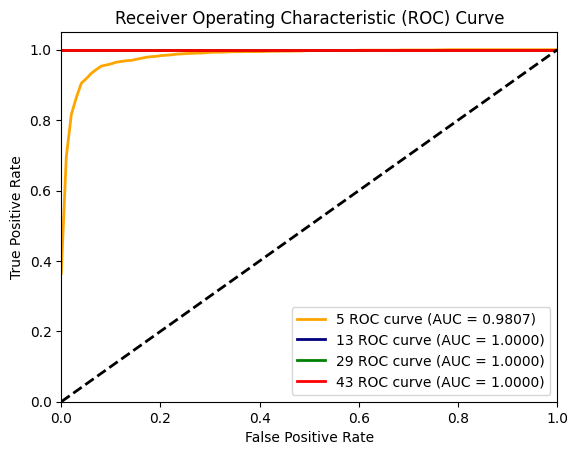

In [39]:
# Plot the ROC curve
plt.figure()
plt.plot(mean_fpr, tpr_5, color='orange', lw=2, label='5 ROC curve (AUC = %0.4f)' % roc_auc_5)
plt.plot(mean_fpr, tpr_13, color='navy', lw=2, label='13 ROC curve (AUC = %0.4f)' % roc_auc_13)
plt.plot(mean_fpr, tpr_29, color='green', lw=2, label='29 ROC curve (AUC = %0.4f)' % roc_auc_29)
plt.plot(mean_fpr, tpr_43, color='red', lw=2, label='43 ROC curve (AUC = %0.4f)' % roc_auc_43)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()